In [ ]:
# Fase 5 – Modelado (CRISP-DM)

En esta fase entrenaremos modelos de Machine Learning utilizando el dataset
enriquecido en la fase de Feature Engineering (`features_dataset.csv`).
El objetivo principal será **predecir la adopción de un animal** en base a sus características.


In [1]:
import pandas as pd
from pathlib import Path

project_path = Path("C:/Users/Ricardo/ricardo-ojeda-machine")
data_path = project_path / "data/04_feature"

# Cargar dataset enriquecido
df = pd.read_csv(data_path / "features_dataset.csv")

print("✅ Dataset cargado:", df.shape)
display(df.head())


✅ Dataset cargado: (3261, 49)


,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found Location,Intake Type,Intake Condition,Animal Type_intake,Sex upon Intake,Age upon Intake,...,stay_weekday_outcome,age_category_intake,stay_category,intake_month,intake_season,Animal Type_intake_enc,Breed_intake_enc,Color_intake_enc,sex_intake_enc,status_intake_enc
0,A006100,Scamp,2014-03-07 14:26:00,March 2014,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6 years,...,Thursday,Adulto (3-7a),Muy largo (>6m),3,Spring,2,367,177,1,1
1,A433746,Evette,2015-10-28 18:41:00,October 2015,Austin (TX),Owner Surrender,Normal,Dog,Spayed Female,9 years,...,Wednesday,Senior (>7a),Corto (<1 sem),10,Fall,2,31,157,0,2
2,A458233,Cinnamon,2017-05-29 09:32:00,May 2017,9401 S 1St St in Austin (TX),Owner Surrender,Normal,Dog,Spayed Female,11 years,...,Friday,Senior (>7a),Muy largo (>6m),5,Spring,2,44,145,0,2
3,A459161,Dugan,2015-04-18 16:02:00,April 2015,W Parmer Ln & Mcneil Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,9 years,...,Sunday,Senior (>7a),Corto (<1 sem),4,Spring,2,355,21,1,1
4,A465637,*Commander,2017-06-04 08:17:00,June 2017,7201 Levander Loop in Austin (TX),Stray,Injured,Dog,Neutered Male,10 years,...,Tuesday,Senior (>7a),Medio (1 sem-1 mes),6,Summer,2,298,70,1,1


In [6]:
# Crear variable binaria de adopción a partir de 'Outcome Type'
if "Outcome Type" in df.columns:
    df["adopted"] = df["Outcome Type"].apply(
        lambda x: 1 if str(x).lower() == "adoption" else 0
    )
    print("✅ Columna target 'adopted' creada.")
    print(df["adopted"].value_counts())
else:
    raise ValueError("No se encontró la columna 'Outcome Type' para crear el target.")

# Definir target
y = df["adopted"]

# Definir features (quitamos IDs, fechas y target)
drop_cols = [
    "Outcome Type",   # la cruda
    "adopted", 
    "Animal ID", 
    "DateTime_intake", 
    "DateTime_outcome"
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("📌 Variables predictoras:", X.shape[1])
print("📌 Target:", y.name)



✅ Columna target 'adopted' creada.
adopted
0    2348
1     913
Name: count, dtype: int64
📌 Variables predictoras: 45
📌 Target: adopted


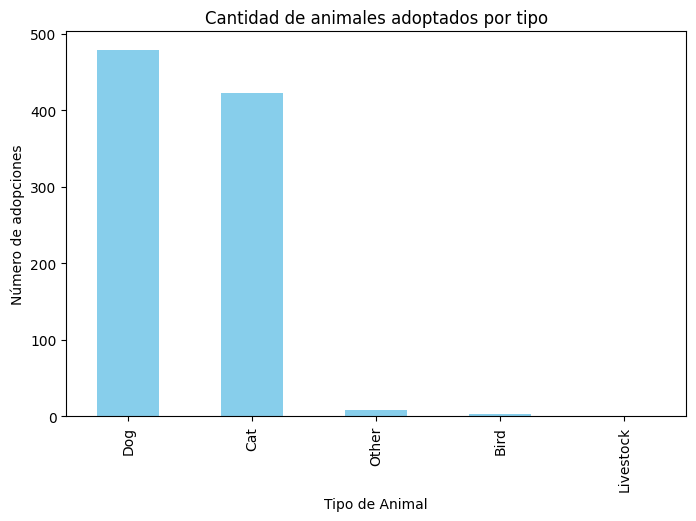

Animal Type_intake
Dog          479
Cat          423
Other          8
Bird           3
Livestock      0
Name: adopted, dtype: int64


In [7]:
import matplotlib.pyplot as plt

if "Animal Type_intake" in df.columns and "adopted" in df.columns:
    adoption_counts = df.groupby("Animal Type_intake")["adopted"].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(8,5))
    adoption_counts.plot(kind="bar", color="skyblue")
    plt.title("Cantidad de animales adoptados por tipo")
    plt.xlabel("Tipo de Animal")
    plt.ylabel("Número de adopciones")
    plt.show()

    print(adoption_counts)
else:
    print("⚠️ No se encontraron las columnas necesarias (Animal Type_intake y adopted).")


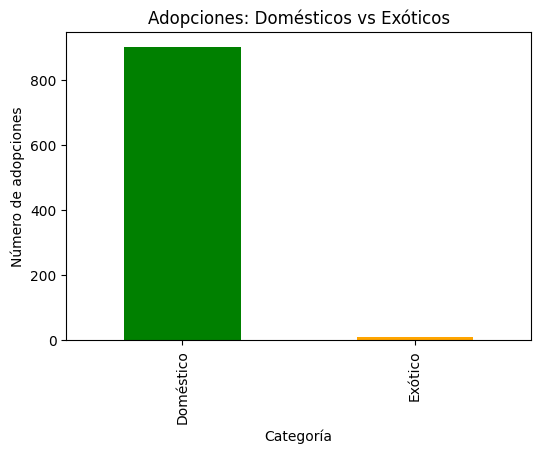

animal_category
Doméstico    902
Exótico       11
Name: adopted, dtype: int64


In [8]:
# Clasificación doméstico/exótico
domesticos = ["Dog", "Cat", "Rabbit", "Hamster"]
df["animal_category"] = df["Animal Type_intake"].apply(
    lambda x: "Doméstico" if str(x) in domesticos else "Exótico"
)

# Conteo de adopciones por categoría
adoption_category = df.groupby("animal_category")["adopted"].sum()

plt.figure(figsize=(6,4))
adoption_category.plot(kind="bar", color=["green", "orange"])
plt.title("Adopciones: Domésticos vs Exóticos")
plt.xlabel("Categoría")
plt.ylabel("Número de adopciones")
plt.show()

print(adoption_category)


In [9]:
from sklearn.model_selection import train_test_split

# Dividir en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train:", X_train.shape, " Test:", X_test.shape)


✅ Train: (2608, 45)  Test: (653, 45)


In [12]:
from sklearn.preprocessing import LabelEncoder

# 1) Columnas que no sirven para modelar
drop_extra = [
    "Name_intake", "Name_outcome", "Date of Birth", 
    "MonthYear_intake", "MonthYear_outcome"
]

X = X.drop(columns=[c for c in drop_extra if c in X.columns])

# 2) Codificar columnas categóricas
encoder = LabelEncoder()
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = encoder.fit_transform(X[col].astype(str))

print("✅ Todas las columnas ahora son numéricas.")
print(X.dtypes.value_counts())


✅ Todas las columnas ahora son numéricas.
int64      33
float64     7
Name: count, dtype: int64


🌳 Árbol de decisión:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       470
           1       0.87      0.96      0.91       183

    accuracy                           0.95       653
   macro avg       0.93      0.95      0.94       653
weighted avg       0.95      0.95      0.95       653



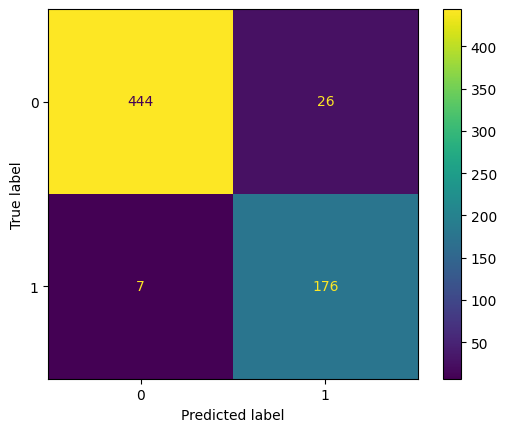

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar árbol
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree.predict(X_test)

print("🌳 Árbol de decisión:\n", classification_report(y_test, y_pred_tree))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)


📈 Regresión logística:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       470
           1       0.64      0.50      0.56       183

    accuracy                           0.78       653
   macro avg       0.73      0.69      0.71       653
weighted avg       0.77      0.78      0.77       653



c:\Users\Ricardo\ricardo-ojeda-machine\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


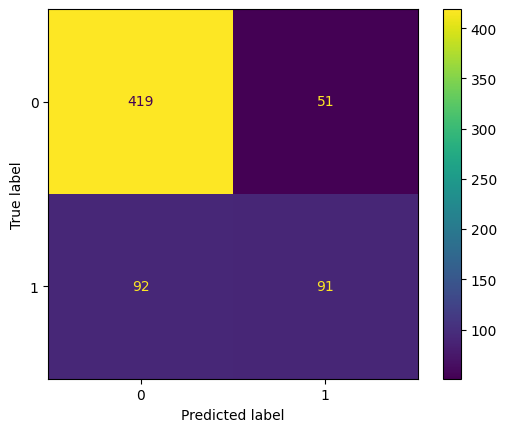

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)

print("📈 Regresión logística:\n", classification_report(y_test, y_pred_log))

ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)


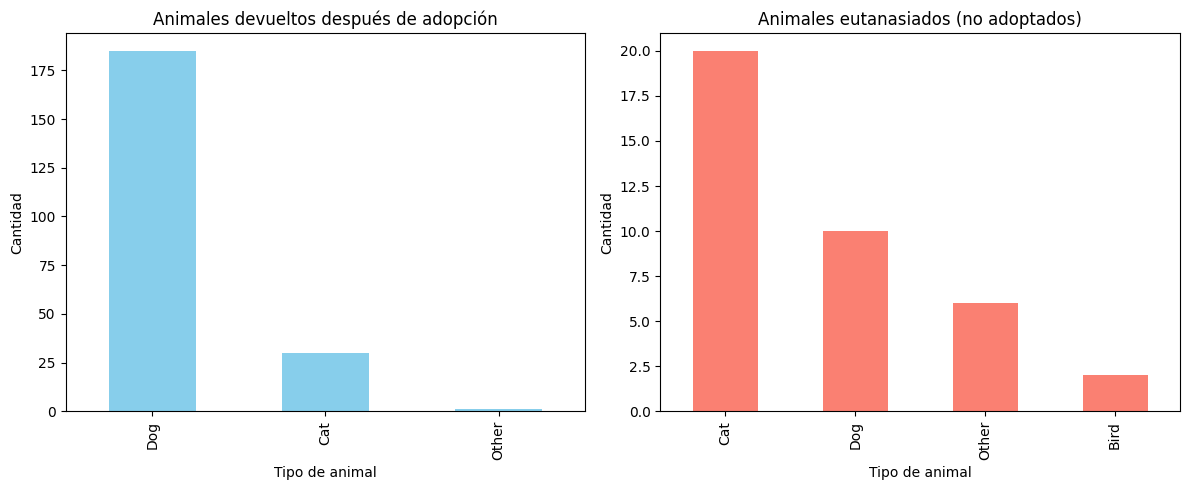

In [15]:
import matplotlib.pyplot as plt

if "Outcome Type" in df.columns and "Outcome Subtype" in df.columns:
    # 1. Filtrar devueltos después de adopción
    returned = df[df["Outcome Type"].str.lower() == "return to owner"]
    
    # También se puede detectar si en "Outcome Subtype" aparece algo relacionado a "Adoption" antes
    # pero como depende del dataset, usamos Outcome Type directo

    # 2. Filtrar eutanasiados
    euthanized = df[df["Outcome Type"].str.lower() == "euthanasia"]

    # Conteo por tipo de animal
    returned_counts = returned["Animal Type_intake"].value_counts()
    euthanized_counts = euthanized["Animal Type_intake"].value_counts()

    # Gráfico comparativo
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    returned_counts.plot(kind="bar", ax=ax[0], color="skyblue")
    ax[0].set_title("Animales devueltos después de adopción")
    ax[0].set_xlabel("Tipo de animal")
    ax[0].set_ylabel("Cantidad")

    euthanized_counts.plot(kind="bar", ax=ax[1], color="salmon")
    ax[1].set_title("Animales eutanasiados (no adoptados)")
    ax[1].set_xlabel("Tipo de animal")
    ax[1].set_ylabel("Cantidad")

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontraron las columnas 'Outcome Type' y 'Outcome Subtype'.")


🌲 Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       470
           1       0.87      0.90      0.89       183

    accuracy                           0.94       653
   macro avg       0.92      0.93      0.92       653
weighted avg       0.94      0.94      0.94       653



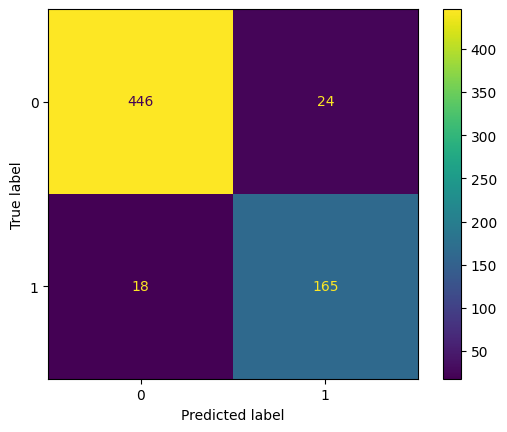

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Entrenar Random Forest
rf = RandomForestClassifier(
    n_estimators=200,      # número de árboles
    max_depth=None,        # sin límite de profundidad
    class_weight="balanced",  # corrige el desbalance (adoptados vs no adoptados)
    random_state=42,
    n_jobs=-1              # usa todos los núcleos del procesador
)
rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test)

# Reporte
print("🌲 Random Forest:\n", classification_report(y_test, y_pred_rf))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)


In [17]:
#"REVISION DE SOBRE AJUSTE
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score

print("Accuracy train:", accuracy_score(y_train, train_pred))
print("Accuracy test:", accuracy_score(y_test, test_pred))


Accuracy train: 1.0
Accuracy test: 0.9356814701378254


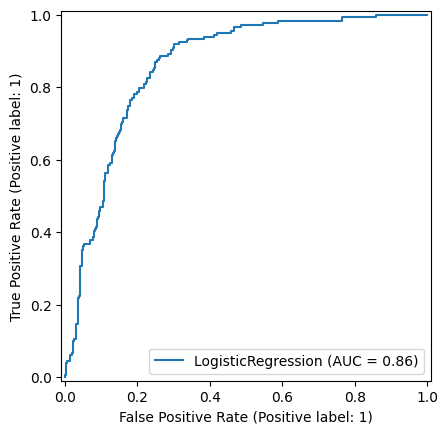

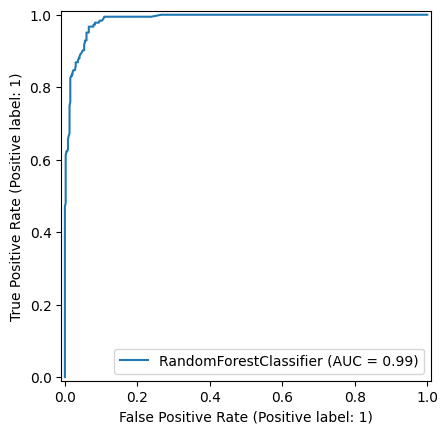

In [18]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logreg, X_test, y_test)
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()


c:\Users\Ricardo\ricardo-ojeda-machine\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


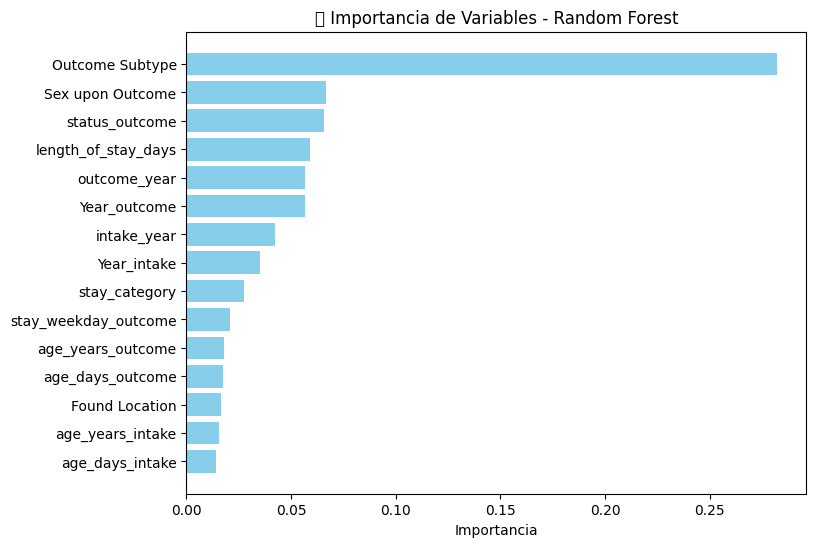

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Importancia de variables
importances = rf.feature_importances_
feat_names = X.columns
feat_imp = pd.DataFrame({"feature": feat_names, "importance": importances})

# Ordenar
feat_imp = feat_imp.sort_values(by="importance", ascending=False).head(15)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_imp["feature"], feat_imp["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("🌲 Importancia de Variables - Random Forest")
plt.xlabel("Importancia")
plt.show()
